<a href="https://colab.research.google.com/github/a3d2ddk/Prenith-and-Drew-Project-Deep-Dive/blob/main/template_demo_from_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Template-pose - 3D unseen object pose estimation from CAD model**

In this notebook, we will use a pre-trained [template-pose](https://nv-nguyen.github.io/template-pose/) checkpoint to estimate 3D pose of unseen objects from CAD models.

First, make sure the notebook is **running on GPU** (`Runtime` > `Change runtime type` > `Hardware accelerator` > `GPU`).

Credit: [Unicorn, ECCV20 by Tom Monnier](https://colab.research.google.com/drive/1-CAHHrcVlacn6zVwTTdrFqpMKUdNh4Km?usp=sharing)

## **1. Setup 👷**

The following cell will setup the notebook environment by cloning the UNICORN repo and downloading the pre-trained model:

In [14]:
import os, glob
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
print('Cloning template-pose repository...')
!git clone --quiet https://github.com/nv-nguyen/template-pose.git
print('template-pose repository cloned!')

# Import
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch

# Install
print('Installing packages...')
!pip -q install gdown omegaconf hydra-core ruamel_yaml trimesh pyrender pytorch-lightning==2.5.5

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:

    %cd /content/drive/MyDrive/pytorch3d_wheels

    wheel_files = glob.glob('*.whl')
    wheel = max(wheel_files, key=os.path.getmtime)
    print("Latest created wheel:", wheel)

    # We try to install PyTorch3D from drive.
    !pip install {wheel}
    #!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

print('Packages installed!')
sys.path.append('template-pose/')
sys.path.append('template-pose/src/')
# Path + download pretrained model
print('Downloading pretrained model...')
os.makedirs("/content/template-pose/pretrained", exist_ok=True)
os.chdir('/content/template-pose/pretrained')
!gdown 1eRSXxELC71cQFTttXBEenb5NUJ5ciSIW -O template_pose_checkpoint.ckpt
print('Model downloaded!')

Cloning template-pose repository...
fatal: destination path 'template-pose' already exists and is not an empty directory.
template-pose repository cloned!
Installing packages...
Packages installed!
Downloading...
From (original): https://drive.google.com/uc?id=1eRSXxELC71cQFTttXBEenb5NUJ5ciSIW
From (redirected): https://drive.google.com/uc?id=1eRSXxELC71cQFTttXBEenb5NUJ5ciSIW&confirm=t&uuid=3715d8c9-f732-4a23-8bc1-49b4c70f35ac
To: /content/template-pose/pretrained/template_pose_checkpoint.ckpt
100% 289M/289M [00:04<00:00, 69.3MB/s]
Model downloaded!


## **2. Loading the model ⌛**

In [16]:
%cd /content/template-pose

import torchvision.transforms as transforms
from tqdm import tqdm
from src.poses.utils import get_obj_poses_from_template_level, adding_inplane_to_pose
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from torchvision.utils import make_grid, save_image
from IPython.display import display
import torch.nn.functional as F
from src.utils.weight import load_checkpoint
import logging
logging.basicConfig(level=logging.INFO)

from hydra.utils import instantiate

/content/template-pose


In [17]:
config = OmegaConf.load("configs/model/resnet50.yaml")
config.pretrained_weight = None
config.log_dir = '/content/template-pose/media/'
config.checkpoint_path = "/content/template-pose/pretrained/template_pose_checkpoint.ckpt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = instantiate(config)
model = model.to(device)

load_checkpoint(
    model,
    config.checkpoint_path,
    prefix="",
    checkpoint_key="state_dict",
)


## **3. Preparing the data 🍪**

In [18]:
# Uncomment the following lines if you want to load your custom images
# %cd demo
# from google.colab import files
# image = files.upload()
# %cd ..

In [39]:
# get examples from repo
def get_examples(dir):
  import glob
  name_example = [
      os.path.join(dir, f)
      for f in os.listdir(dir)
      if os.path.isdir(os.path.join(dir, f))
  ]
  examples = []  # query, cad
  for name in name_example:
      query_paths = glob.glob(os.path.join(name, "query*.png"))
      for query_path in query_paths:
          dataset_name, obj_id = os.path.basename(name).split("_")
          cad_path = os.path.join(name, f"obj_{int(obj_id):06d}.ply")
          examples.append([dataset_name, int(obj_id), query_path, cad_path])
          #break
  return examples

examples = get_examples("/content/template-pose/media/demo")
index_selected_sample = 3 # @param {type:"slider", min:0, max:10, step:1}
selected_sample = examples[index_selected_sample]
print(selected_sample)

# select one example to test
dataset_name = selected_sample[0]
obj_id = selected_sample[1]
query = Image.open(selected_sample[2])
cad_query = selected_sample[3]

# define save dir
save_dir = "/content/template-pose/results/"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(os.path.join(save_dir, dataset_name), exist_ok=True)

# create object poses
level = 2 # change to 2 if you want more dense (and precise) template

template_poses = get_obj_poses_from_template_level(
        level=level, pose_distribution="all"
    )
template_poses[:, :3, 3] *= 0.4  # zoom to object, setting =1/diamter in case you don't know how much to zoom in
obj_pose_path = os.path.join(save_dir, dataset_name, "obj_poses")
template_dir = os.path.join(save_dir, dataset_name, f"{obj_id:06d}")
os.makedirs(template_dir, exist_ok=True)
gpus_devices = "0"
np.save(obj_pose_path, template_poses)


# render templates
print("Starting render templates (can take around 1 minute)...")
render_command = f"python -m src.poses.pyrender {cad_query} {obj_pose_path}.npy {template_dir} {gpus_devices} false"
os.system(render_command)
print("Rendering templates done!")

['lm', 5, '/content/template-pose/media/demo/lm_05/query_0.png', '/content/template-pose/media/demo/lm_05/obj_000005.ply']
Starting render templates (can take around 1 minute)...
Rendering templates done!


In [40]:
img_size, mask_size = 256, 32

rgb_transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
mask_transform = transforms.Compose(
    [
        transforms.Resize((mask_size, mask_size)),
        transforms.Lambda(lambda mask: (np.asarray(mask) / 255.0 > 0) * 1),
        transforms.Lambda(lambda mask: torch.from_numpy(mask).unsqueeze(0)),
    ]
)

rgb_transform_inverse = transforms.Compose(
    [
        transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        ),
    ]
)

# make a square crop without changing respect ratio
def make_bbox_square(old_bbox):
  size_to_fit = np.max([old_bbox[2] - old_bbox[0], old_bbox[3] - old_bbox[1]])
  new_bbox = np.array(old_bbox)
  old_bbox_size = [old_bbox[2] - old_bbox[0], old_bbox[3] - old_bbox[1]]
  # Add padding into y axis
  displacement = int((size_to_fit - old_bbox_size[1]) / 2)
  new_bbox[1] = old_bbox[1] - displacement
  new_bbox[3] = old_bbox[3] + displacement
  # Add padding into x axis
  displacement = int((size_to_fit - old_bbox_size[0]) / 2)
  new_bbox[0] = old_bbox[0] - displacement
  new_bbox[2] = old_bbox[2] + displacement
  return new_bbox


In [41]:
query_tensor = rgb_transform(query).unsqueeze(0)

list_templates, list_template_masks, list_template_poses = [], [], []
template_paths = sorted(os.listdir(template_dir))
for idx_template in tqdm(range(len(template_paths))):
  template_path = os.path.join(template_dir, template_paths[idx_template])
  template_full = Image.open(template_path)
  for in_plane in np.arange(0, 360, 10):
    template_full_clone = template_full.copy()
    template_full_clone = template_full_clone.rotate(in_plane)
    # cropping with bboxing box of template
    template_bbox = make_bbox_square(template_full_clone.getbbox())
    template = template_full_clone.crop(template_bbox)
    template_mask = template.getchannel("A")
    template = template.convert("RGB")
    template = rgb_transform(template)
    template_mask = mask_transform(template_mask)
    list_templates.append(template)
    list_template_masks.append(template_mask)

    # pose of template
    template_pose = template_poses[idx_template][:3, :3]
    pose = adding_inplane_to_pose(pose=template_pose, inplane=in_plane)
    list_template_poses.append(torch.from_numpy(pose))
list_templates = torch.stack(list_templates)
list_template_masks = torch.stack(list_template_masks)
list_template_poses = torch.stack(list_template_poses)
print(f"query: {query_tensor.shape}, templates: {list_templates.shape}, template masks: {list_template_masks.shape}")

100%|██████████| 42/42 [00:07<00:00,  5.55it/s]


query: torch.Size([1, 3, 256, 256]), templates: torch.Size([1512, 3, 256, 256]), template masks: torch.Size([1512, 1, 32, 32])


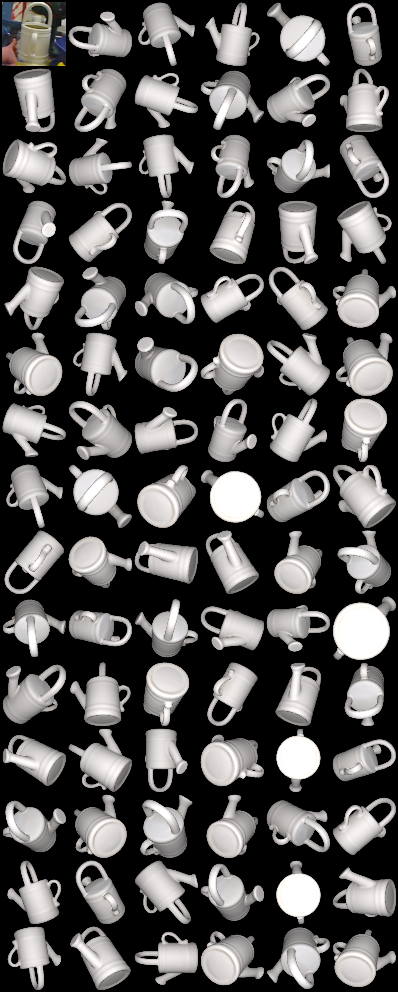

In [42]:
# Display query and templates
num_templates_to_visualize = 89
index_visualized_templates = np.random.randint(0, len(list_templates), num_templates_to_visualize)
all_visualized_images = torch.cat((query_tensor, list_templates[index_visualized_templates]))
all_visualized_images = rgb_transform_inverse(all_visualized_images)
all_visualized_images = F.interpolate(all_visualized_images, size=(64, 64), mode="nearest")
results_dir = os.path.join(save_dir, dataset_name, "template_pose_results")
os.makedirs(results_dir, exist_ok=True)
save_image(all_visualized_images,
          os.path.join(results_dir, "vis_img.png"),
          nrow=6,
      )
display(Image.open(os.path.join(results_dir, "vis_img.png")))

## **4. Inference 🚀**

In [43]:
with torch.no_grad():
  feat_query = model(query_tensor.to(device))

  # get template features by batch
  batch_size = 8
  list_feat_templates = []
  for start_index in tqdm(range(0, len(list_templates), batch_size)):
    templates = list_templates[start_index:start_index+batch_size]
    feat_template = model(templates.to(device))
    list_feat_templates.append(feat_template)
list_feat_templates = torch.cat(list_feat_templates, dim=0)

100%|██████████| 189/189 [00:30<00:00,  6.21it/s]


In [44]:
# find nearest neighbors
matrix_sim = model.calculate_similarity_for_search(
      feat_query,
      list_feat_templates,
      list_template_masks.to(device),
      training=False,
  )
k = 5 # number of neighbors to display
weight_sim, pred_index = matrix_sim.topk(k=k)

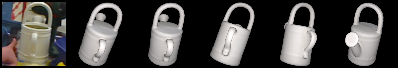

In [45]:
# display found template and predicted poses
pred_index = pred_index.cpu()
predicted_templates = list_templates[pred_index.reshape(-1)]
all_visualized_images = torch.cat((query_tensor, predicted_templates))
all_visualized_images = rgb_transform_inverse(all_visualized_images)
all_visualized_images = F.interpolate(all_visualized_images, size=(64, 64), mode="nearest")
results_dir = os.path.join(save_dir, dataset_name, "template_pose_results")
os.makedirs(results_dir, exist_ok=True)
save_image(all_visualized_images,
          os.path.join(results_dir, "predictions.png"),
          nrow=k+1,
      )
display(Image.open(os.path.join(results_dir, "predictions.png")))
# nearest to farthest

In [46]:
# display its pose
predicted_pose = list_template_poses[pred_index.reshape(-1)]
print(predicted_pose[:])

tensor([[[ 0.8055,  0.5763,  0.1380],
         [-0.4946,  0.7821, -0.3790],
         [-0.3263,  0.2371,  0.9150]],

        [[ 0.7074,  0.7033,  0.0700],
         [-0.6270,  0.6702, -0.3972],
         [-0.3263,  0.2371,  0.9150]],

        [[ 0.5065, -0.8540,  0.1188],
         [ 0.8323,  0.4482, -0.3263],
         [ 0.2254,  0.2641,  0.9378]],

        [[-0.8547, -0.5155,  0.0603],
         [ 0.4675, -0.8152, -0.3419],
         [ 0.2254, -0.2641,  0.9378]],

        [[-0.1589, -0.9848,  0.0700],
         [ 0.9011, -0.1736, -0.3972],
         [ 0.4034,  0.0000,  0.9150]]], dtype=torch.float64)
